# Self Data Analysis 1  

Titanic Dataset from: https://www.kaggle.com/competitions/titanic/data?select=train.csv   
This is round 2 after linear regression didn't work well.   
Arush Bodla

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data = pd.read_csv("data/titanic_train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'm going to remove all of the columns with fully unique values since they wouldn't be of much use. I'll also do some preprocessing.

In [4]:
from sklearn.preprocessing import OrdinalEncoder


data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], errors="ignore", inplace=True)
data.dropna(inplace=True)
encoder = OrdinalEncoder()
for col in data.select_dtypes("object").columns:
    data[col] = encoder.fit_transform(data[[col]])

0.4044943820224719


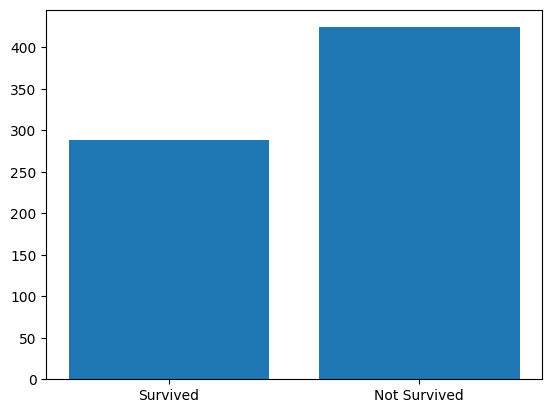

In [5]:
survived = data[data["Survived"] == 1]
not_survived = data[data["Survived"] == 0]
plt.bar(["Survived", "Not Survived"], [survived.shape[0], not_survived.shape[0]])
print(np.mean(data["Survived"]))

About 40% of the people survived, which means the data is somewhat balanced. I'll see if there's any colinearity in the data.


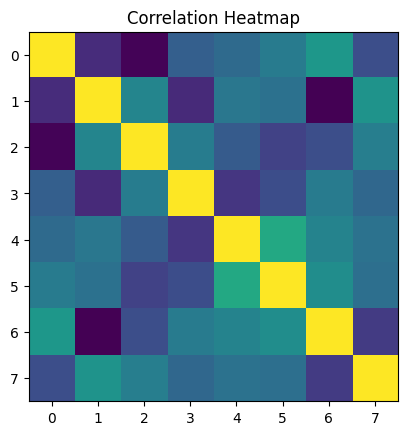

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Life Expectancy Correlation Heatmap', fontdict={'fontsize':14}, pad=16);
plt.show()

## Testing Various Models

In [6]:
X = data.drop(columns=["Survived"])
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I'll try K nearest neighbors first.

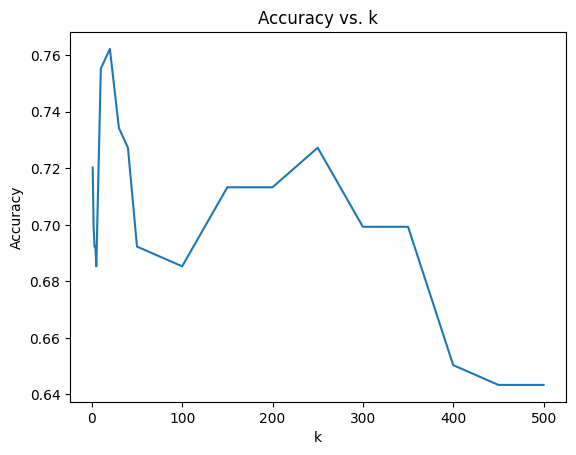

Best k: 20 
Accuracy: 0.7622377622377622


In [7]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
model.score(X_test, y_test)

k_values = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    
plt.title("Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(k_values, scores)
plt.show()
print("Best k:", k_values[np.argmax(scores)], "\nAccuracy:", np.max(scores))

It looks like k=40 is the best amount, but the model is still bad overall. I'll see if other parameters can make it better.

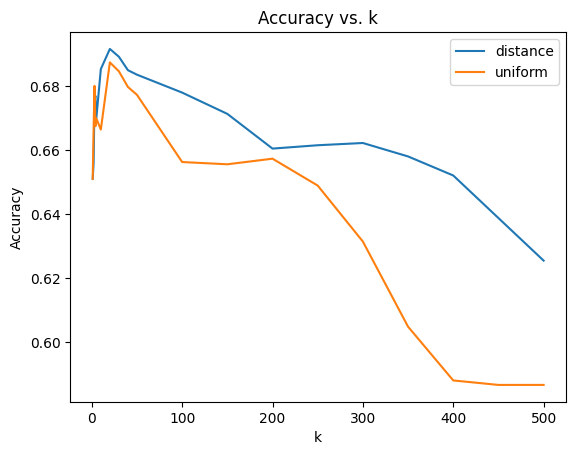

In [16]:
def test_distance_uniform():
    scored = []
    scoreu = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, weights="distance")
        model.fit(X_train, y_train)
        scored.append(model.score(X_test, y_test))
        model = KNeighborsClassifier(n_neighbors=k, weights="uniform")
        model.fit(X_train, y_train)
        scoreu.append(model.score(X_test, y_test))
    return np.array(scored), np.array(scoreu)

scoredtotal = np.zeros(len(k_values))
scoreutotal = np.zeros(len(k_values))
for i in range(20):
    scored, scoreu = test_distance_uniform()
    scoredtotal += scored
    scoreutotal += scoreu
    
scored = scoredtotal / (20)
scoreu = scoreutotal / (20)

plt.title("Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(k_values, scored, label="distance")
plt.plot(k_values, scoreu, label="uniform")
plt.legend()
plt.show()

In [18]:
print("Best k (distance):", k_values[np.argmax(scored)], "\nAccuracy:", np.max(scored))
print("Best k (uniform):", k_values[np.argmax(scoreu)], "\nAccuracy:", np.max(scoreu))

Best k (distance): 20 
Accuracy: 0.6916083916083917
Best k (uniform): 20 
Accuracy: 0.6874125874125875


Looks like distance is the better option.

Brute Force: 0.6993006993006993
KD Tree: 0.6993006993006993
Ball Tree: 0.6993006993006993


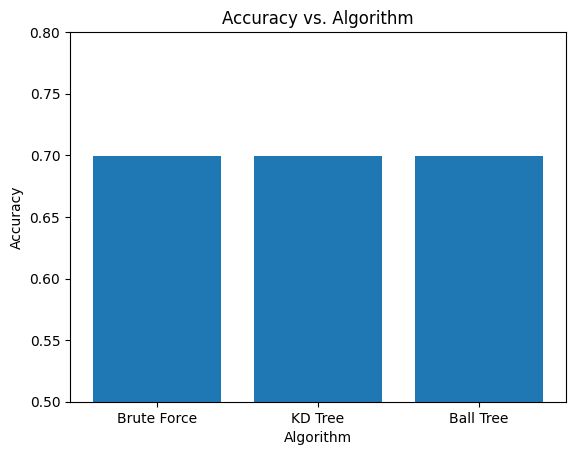

In [24]:
model = KNeighborsClassifier(n_neighbors=40, weights="distance", algorithm="brute")
model.fit(X_train, y_train)
brute = model.score(X_test, y_test)

model = KNeighborsClassifier(n_neighbors=40, weights="distance", algorithm="kd_tree")
model.fit(X_train, y_train)
kd_tree = model.score(X_test, y_test)

model = KNeighborsClassifier(n_neighbors=40, weights="distance", algorithm="ball_tree")
model.fit(X_train, y_train)
ball_tree = model.score(X_test, y_test)

print("Brute Force:", brute)
print("KD Tree:", kd_tree)
print("Ball Tree:", ball_tree)

plt.title("Accuracy vs. Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.bar(["Brute Force", "KD Tree", "Ball Tree"], [brute, kd_tree, ball_tree])
plt.ylim(0.5, 0.8)
plt.show()

They're all identical, so I'll leave the algorithm at auto. The final KNN classifier is below:

In [25]:
model = KNeighborsClassifier(n_neighbors=40, weights="distance", algorithm="auto")
model.fit(X_train, y_train)
print("Accuracy: ", model.score(X_test, y_test))

Accuracy:  0.6993006993006993
